# SRLite assessment tool
## Assess the performance metrics of a batch of SRlite
r2_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [1]:
import plotnine
from plotnine import *
import pandas as pd
import glob

import os, sys
sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib

import numpy as np
import geopandas as gpd

/home/pmontesa/.local/lib/python3.8/site-packages/plotnine/geoms/geom_map.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).


In [2]:
import importlib
importlib.reload(footprintlib)

<module 'footprintlib' from '/home/pmontesa/code/geoscitools/footprintlib.py'>

# SRlite metrics analysis (example)  
- use this to filter validation & to inform training chip selection so you dont train with chips from bad data  
- develop this for Alaska in `code/geoscitools/above_shrubs_model_plan.ipynb`

#### Note: below SR data is a Senegal example, b/c metrics CSVs exist - switch to Alaska once CSVs are ready

In [3]:
# region_df_list = []
# SRLITE_REG_CHOICE = 'RMA'
# for REGION in ['CAS','ETZ','SRV']:
#     OUTDIR_TMP = f'/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/senegal/{REGION}/csv'
#     srlite_metrics_df = pd.concat([footprintlib.get_attributes_from_filename(pd.read_csv(csv_fn), f'SR ({REGION})', f'_{SRLITE_REG_CHOICE}_SRLite_statistics', filename=os.path.basename(csv_fn), DROP_FILE_DUPLICATES=False) for csv_fn in glob.glob(OUTDIR_TMP + '/*.csv')])
#     region_df_list.append(srlite_metrics_df)

# srlite_metrics_df = pd.concat(region_df_list)

## SRlite metrics csvs for Alaska batches

In [65]:
def CHECK_CSV(csv_fn, COLS_TO_CHECK_4_BAD_VALS=['intercept','slope','r2_score']):
    '''Check csv for bad values; return True if good, False if bad
    Bad values result in 'object' type for certain columns
    This happens b/c of a bug in srlite during 'ols' regression that is returning a list of a single value instead of just a single value
    '''
    df = pd.read_csv(csv_fn)
    N_COLS_BAD_VALS = df[COLS_TO_CHECK_4_BAD_VALS].select_dtypes(include=['object']).shape[1]
    if N_COLS_BAD_VALS > 0:
        return False
    else:
        return True
    

#### Note
srlite output from choice 'ols' seems to produce CSVs 

In [152]:
csv_fn_list = []
csv_fn_list_bad = []
srlite_df_list = []
srlite_df_list_bad = []

SRLITE_REG_CHOICE = 'rma'
BATCH_LIST = ['batch_1', 'batch_2']

for BATCH in BATCH_LIST:
  
    for BAND_GROUP in ['4_band_csv','8_band_csv']:
        
        # Build these lists of csv names for concat into df
        band_group_csv_fn_list = []
        band_group_csv_fn_list_bad = []
        
        OUTDIR_TMP = f'/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/{BATCH}/{BAND_GROUP}/**/csv'    
        
        for csv_fn in  glob.glob(OUTDIR_TMP + f'/*{SRLITE_REG_CHOICE}_SRLite_statistics.csv', recursive=True):
            if CHECK_CSV(csv_fn) == True:
                band_group_csv_fn_list.append(csv_fn)
                csv_fn_list.append(csv_fn)
            else:
                band_group_csv_fn_list_bad.append(csv_fn)
                csv_fn_list_bad.append(csv_fn)
        
        if len(band_group_csv_fn_list) > 0:
            srlite_metrics_df = pd.concat([footprintlib.get_attributes_from_filename(pd.read_csv(csv_fn), f'SR ({BATCH} {BAND_GROUP})', f'_{SRLITE_REG_CHOICE}_SRLite_statistics', filename=os.path.basename(csv_fn), DROP_FILE_DUPLICATES=False) for csv_fn in band_group_csv_fn_list ] )
            srlite_df_list.append(srlite_metrics_df)
        
        if len(band_group_csv_fn_list_bad) > 0:
            srlite_metrics_bad_df = pd.concat([footprintlib.get_attributes_from_filename(pd.read_csv(csv_fn), f'SR ({BATCH} {BAND_GROUP})', f'_{SRLITE_REG_CHOICE}_SRLite_statistics', filename=os.path.basename(csv_fn), DROP_FILE_DUPLICATES=False) for csv_fn in band_group_csv_fn_list_bad ] )
            srlite_df_list_bad.append(srlite_metrics_bad_df)

srlite_metrics_df = pd.concat(srlite_df_list)


In [154]:
if len(csv_fn_list_bad) > 0:
    csv_fn_list_bad[0]
    pd.read_csv(csv_fn_list_bad[0])

In [153]:
srlite_metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22896 entries, 0 to 7
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          22896 non-null  int64         
 1   index               22896 non-null  int64         
 2   band_name           22896 non-null  object        
 3   model               22896 non-null  object        
 4   intercept           22896 non-null  float64       
 5   slope               22896 non-null  float64       
 6   r2_score            11772 non-null  float64       
 7   explained_variance  11772 non-null  float64       
 8   mbe                 11772 non-null  float64       
 9   mae                 11772 non-null  float64       
 10  mape                11772 non-null  float64       
 11  medae               11772 non-null  float64       
 12  mse                 11772 non-null  float64       
 13  rmse                11772 non-null  float64       

In [156]:
#srlite_metrics_df[srlite_metrics_df.catid == '1030010005333400']

## Find SRlite catids that have been processed in multiple batches
use `band_count` to find this info

In [157]:
# Use dropna() to remove rows with NaN that will appear for 4_band_csv outputs and erroneously effect the summary counts 
count_catid_bands = srlite_metrics_df.groupby(['catid','type']).aggregate(band_count=('band_name','count'), sensor=('sensor','first')).reset_index() 
count_catid_bands

,catid,type,band_count,sensor
0,10300100045FA300,SR (batch_1 4_band_csv),4,WV02
1,1030010005215900,SR (batch_1 4_band_csv),4,WV02
2,1030010005333400,SR (batch_1 8_band_csv),8,WV02
3,10300100053C1900,SR (batch_1 4_band_csv),4,WV02
4,1030010005429600,SR (batch_2 8_band_csv),8,WV02
...,...,...,...,...
2932,104001005F903300,SR (batch_1 8_band_csv),8,WV03
2933,104001005F95B200,SR (batch_1 8_band_csv),8,WV03
2934,104001005FBD0800,SR (batch_1 8_band_csv),8,WV03
2935,104001005FCF3300,SR (batch_2 8_band_csv),8,WV03


In [158]:
# Check df of a single catid
CHECK_CATID = '104001005FBD0800'
srlite_metrics_df[srlite_metrics_df.catid == CHECK_CATID]

,Unnamed: 0,index,band_name,model,intercept,slope,r2_score,explained_variance,mbe,mae,...,mae_norm,rmse_norm,file,type,footprint_name,catid,sensor,year,month,date
0,0,0,Blue,rma,-0.005134,0.544523,0.295247,0.295267,0.000049,0.004091,...,0.074998,0.170023,WV03_20200711_M1BS_104001005FBD0800_rma_SRLite...,SR (batch_1 8_band_csv),WV03_20200711_M1BS_104001005FBD0800,104001005FBD0800,WV03,2020,7,2020-07-11
1,1,0,Green,rma,0.028082,0.530000,0.025002,0.025154,0.000122,0.004680,...,0.060074,0.125657,WV03_20200711_M1BS_104001005FBD0800_rma_SRLite...,SR (batch_1 8_band_csv),WV03_20200711_M1BS_104001005FBD0800,104001005FBD0800,WV03,2020,7,2020-07-11
2,2,0,Red,rma,0.035862,0.544023,0.006463,0.006558,0.000108,0.005730,...,0.067903,0.130745,WV03_20200711_M1BS_104001005FBD0800_rma_SRLite...,SR (batch_1 8_band_csv),WV03_20200711_M1BS_104001005FBD0800,104001005FBD0800,WV03,2020,7,2020-07-11
3,3,0,NIR,rma,-0.002658,1.184433,0.875019,0.875022,0.000117,0.014953,...,0.057577,0.095617,WV03_20200711_M1BS_104001005FBD0800_rma_SRLite...,SR (batch_1 8_band_csv),WV03_20200711_M1BS_104001005FBD0800,104001005FBD0800,WV03,2020,7,2020-07-11
4,4,0,Coastal,rma,-0.005134,0.544523,NaN,NaN,NaN,NaN,...,NaN,NaN,WV03_20200711_M1BS_104001005FBD0800_rma_SRLite...,SR (batch_1 8_band_csv),WV03_20200711_M1BS_104001005FBD0800,104001005FBD0800,WV03,2020,7,2020-07-11
5,5,0,Yellow,rma,0.032182,0.537390,NaN,NaN,NaN,NaN,...,NaN,NaN,WV03_20200711_M1BS_104001005FBD0800_rma_SRLite...,SR (batch_1 8_band_csv),WV03_20200711_M1BS_104001005FBD0800,104001005FBD0800,WV03,2020,7,2020-07-11
6,6,0,RedEdge,rma,0.021263,0.786738,NaN,NaN,NaN,NaN,...,NaN,NaN,WV03_20200711_M1BS_104001005FBD0800_rma_SRLite...,SR (batch_1 8_band_csv),WV03_20200711_M1BS_104001005FBD0800,104001005FBD0800,WV03,2020,7,2020-07-11
7,7,0,NIR2,rma,-0.002658,1.184433,NaN,NaN,NaN,NaN,...,NaN,NaN,WV03_20200711_M1BS_104001005FBD0800_rma_SRLite...,SR (batch_1 8_band_csv),WV03_20200711_M1BS_104001005FBD0800,104001005FBD0800,WV03,2020,7,2020-07-11


#### If I group catids by their band_count, i can find duplicates...

In [159]:
count_catid_bands.groupby(['band_count','type']).aggregate(catid_count=('band_count','count')).reset_index() 

,band_count,type,catid_count
0,4,SR (batch_1 4_band_csv),162
1,8,SR (batch_1 8_band_csv),1915
2,8,SR (batch_2 8_band_csv),854
3,16,SR (batch_1 8_band_csv),1
4,16,SR (batch_2 8_band_csv),5


#### Duplicates will be where `band_count` doesnt match the `type`

#### Across all batches, I use a `BAND_COUNT_VAL` to find the catids where there are more bands than their band count, indicating duplicate data

In [177]:
for BAND_COUNT_VAL in [4, 8]:
    agg_df = pd.concat([srlite_metrics_df[srlite_metrics_df.type == CHECK_TYPE].groupby(['catid','type']).aggregate(catid_count=('catid','count')).reset_index() for CHECK_TYPE in [f'SR ({BATCH} {BAND_COUNT_VAL}_band_csv)' for BATCH in BATCH_LIST] ] )
    dup_catid_df = agg_df[agg_df.catid_count > BAND_COUNT_VAL]
    print(dup_catid_df)

Empty DataFrame
Columns: [catid, type, catid_count]
Index: []
                catid                     type  catid_count
124  1030010024CC3100  SR (batch_1 8_band_csv)           16
276  1030010092635900  SR (batch_2 8_band_csv)           16
297  103001009367EC00  SR (batch_2 8_band_csv)           16
318  103001009409EB00  SR (batch_2 8_band_csv)           16
363  103001009561CF00  SR (batch_2 8_band_csv)           16
528  10300100A622DE00  SR (batch_2 8_band_csv)           16


In [191]:
# Check df of a single catid
BATCH = 'batch_1'
BAND_COUNT_VAL = 8
CHECK_CATID = '1030010024CC3100'
#srlite_metrics_df[(srlite_metrics_df.catid == CHECK_CATID)]
srlite_metrics_df[(srlite_metrics_df.catid == CHECK_CATID) & (srlite_metrics_df.type == f'SR ({BATCH} {BAND_COUNT_VAL}_band_csv)')]

,Unnamed: 0,index,band_name,model,intercept,slope,r2_score,explained_variance,mbe,mae,...,mae_norm,rmse_norm,file,type,footprint_name,catid,sensor,year,month,date
0,0,0,Blue,rma,-0.194907,1.880811,-0.011984,-0.011984,0.000003,0.030029,...,0.501786,0.986751,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17
1,1,0,Green,rma,-0.086716,1.465856,0.297502,0.298921,0.002281,0.024398,...,0.333951,0.694606,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17
2,2,0,Red,rma,-0.046709,1.445930,0.303209,0.304505,0.002195,0.022857,...,0.425618,0.947888,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17
3,3,0,NIR,rma,0.006447,0.959643,0.730470,0.730837,0.002542,0.038815,...,0.266230,0.472485,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17
4,4,0,Coastal,rma,-0.194907,1.880811,NaN,NaN,NaN,NaN,...,NaN,NaN,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17
5,5,0,Yellow,rma,-0.065632,1.455355,NaN,NaN,NaN,NaN,...,NaN,NaN,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17
6,6,0,RedEdge,rma,-0.026563,1.261627,NaN,NaN,NaN,NaN,...,NaN,NaN,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17
7,7,0,NIR2,rma,0.006447,0.959643,NaN,NaN,NaN,NaN,...,NaN,NaN,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17
0,0,0,Blue,rma,-0.128475,1.364619,0.014768,0.014769,0.000029,0.014921,...,0.272964,0.800061,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17
1,1,0,Green,rma,-0.068293,1.249035,0.259618,0.260359,0.001196,0.015297,...,0.217746,0.538176,WV02_20130617_M1BS_1030010024CC3100_rma_SRLite...,SR (batch_1 8_band_csv),WV02_20130617_M1BS_1030010024CC3100,1030010024CC3100,WV02,2013,6,2013-06-17


In [206]:
dup_catid_list = dup_catid_df.catid.to_list()

In [208]:
# find the corresponding csv in the list
[csv_fn for csv_fn in csv_fn_list for dup_catid in dup_catid_list if dup_catid in csv_fn]

['/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_3/csv/WV02_20130617_M1BS_1030010024CC3100_rma_SRLite_statistics.csv',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_1/8_band_csv/split_4/csv/WV02_20130617_M1BS_1030010024CC3100_rma_SRLite_statistics.csv',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_2/8_band_csv/split_4/csv/WV02_20190620_M1BS_1030010092635900_rma_SRLite_statistics.csv',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_2/8_band_csv/split_4/csv/WV02_20190620_M1BS_103001009409EB00_rma_SRLite_statistics.csv',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_2/8_band_csv/split_5/csv/WV02_20190619_M1BS_103001009367EC00_rma_SRLite_statistics.csv',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/batch_2/8_band_csv/split_5/csv/WV

### Get vhr metadata from associated TOAs

In [12]:
#TODO

### Apply hotspot metric calc (tiangang)

In [241]:
#TODO

### Show interactive map of an SRlite strip

In [242]:
#TODO

### Find catid for which all bands have r2_score > threshold

In [209]:
THRESH_R2_SCORE = 0.25

In [233]:
# Dont use Blue band

In [228]:
smry_catid_r2_score = srlite_metrics_df[srlite_metrics_df.band_name != 'Blue'].groupby(['catid','band_name']).aggregate({'r2_score':'first'}).reset_index().groupby(['catid']).aggregate({'r2_score':'min'}).rename(columns={'r2_score':'r2_score_band_min'}).reset_index()
print(smry_catid_r2_score.shape)
smry_catid_r2_score.head()

(2937, 2)


,catid,r2_score_band_min
0,10300100045FA300,-0.518866
1,1030010005215900,-0.278633
2,1030010005333400,-0.970634
3,10300100053C1900,-0.193900
4,1030010005429600,-0.026584


In [229]:
proportion_gt_thresh_r2_score = np.round(len(smry_catid_r2_score[smry_catid_r2_score.r2_score_band_min > THRESH_R2_SCORE])/ len(smry_catid_r2_score), 3) * 100
proportion_gt_thresh_r2_score = proportion_gt_thresh_r2_score.astype(str) + '%'
proportion_gt_thresh_r2_score

'51.9%'

## Get final set of SRlite to use for training and model application

In [230]:
def classifier(row):
    if row["r2_score_band_min"] >= THRESH_R2_SCORE:
        return "include"
    else:
        return "exclude"

smry_catid_r2_score["srlite_use_class"] = smry_catid_r2_score.apply(classifier, axis=1)

In [231]:
# reminder - some r2_score values can be less than -1
smry_catid_r2_score[smry_catid_r2_score.r2_score_band_min < -1]

,catid,r2_score_band_min,srlite_use_class
124,103001000D7D8000,-1.825024,exclude
619,1030010038974900,-1.006167,exclude
703,1030010044A25100,-1.274660,exclude
1419,103001008EC78A00,-103.077384,exclude
1790,10300100A437D200,-1.091414,exclude
2801,104001005A47F000,-1.035892,exclude


/home/pmontesa/.local/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin : Removed 1 rows containing non-finite values.
/home/pmontesa/.local/lib/python3.8/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


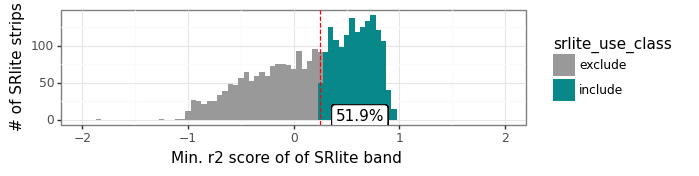

<ggplot: (1447126031824)>

In [232]:
(
    ggplot(smry_catid_r2_score.dropna())
    + geom_histogram(aes(x='r2_score_band_min', fill='srlite_use_class'), binwidth=0.05)
    + scale_fill_manual(values=['#999999','#088888'], name='')
    + geom_vline(xintercept=THRESH_R2_SCORE, color='red', linetype='dashed')
    + scale_x_continuous(limits=(-2,2))
    + theme_bw()
    + theme(figure_size=(6,1.5))
    + labs(y='# of SRlite strips', x='Min. r2 score of of SRlite band')
    + geom_label(aes(x= THRESH_R2_SCORE + ( 0.5 * (1-THRESH_R2_SCORE)), y=5), label= (proportion_gt_thresh_r2_score))
    
)

### Make list of catids to include in modeling (train, apply)

In [234]:
# Get list of catids of class 'include'
list_catids_include = smry_catid_r2_score[smry_catid_r2_score.srlite_use_class == 'include'].catid.to_list()
len(list_catids_include)

1525

In [235]:
# from code/geoscitools/footprint_vhr_AK.ipynb
footprints_vhr_meta_SR_gdf = gpd.read_file('/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_SR_alaska.gpkg')
footprints_vhr_meta_SR_gdf[footprints_vhr_meta_SR_gdf.catid.isin(list_catids_include)].cx[-180:-125,50:75].to_crs(3338).plot(figsize=(10,5), alpha=0.5)

<AxesSubplot: >

## Plots show metrics separated by threshold of r2 score

NOTE! 8-band data only has values for slope and intercept - doesnt plot nicely - remove with `.dropna()`  

In [236]:
srlite_metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22896 entries, 0 to 7
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          22896 non-null  int64         
 1   index               22896 non-null  int64         
 2   band_name           22896 non-null  object        
 3   model               22896 non-null  object        
 4   intercept           22896 non-null  float64       
 5   slope               22896 non-null  float64       
 6   r2_score            11772 non-null  float64       
 7   explained_variance  11772 non-null  float64       
 8   mbe                 11772 non-null  float64       
 9   mae                 11772 non-null  float64       
 10  mape                11772 non-null  float64       
 11  medae               11772 non-null  float64       
 12  mse                 11772 non-null  float64       
 13  rmse                11772 non-null  float64       

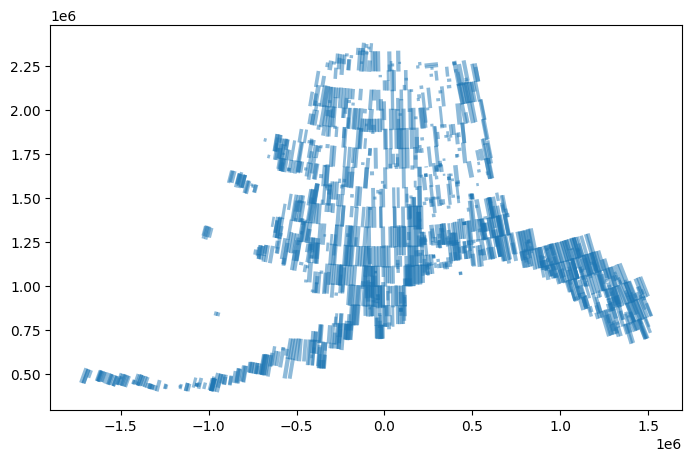

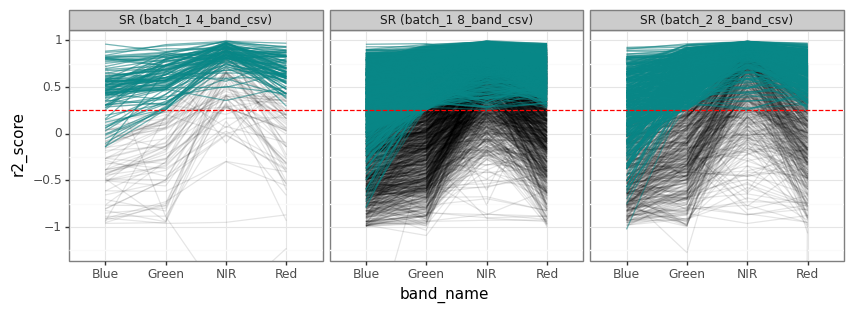

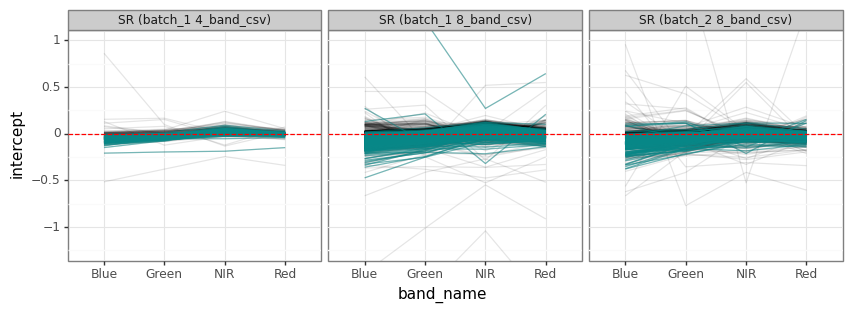

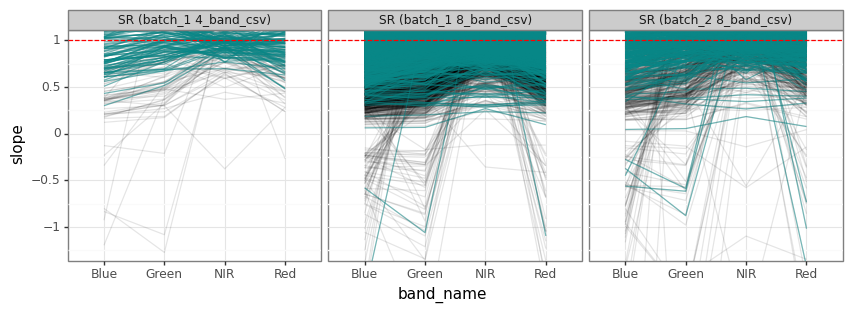

In [237]:

SUBSET_DF = srlite_metrics_df[srlite_metrics_df.catid.isin(list_catids_include)].dropna()
HLINE = [THRESH_R2_SCORE, 0, 1]

for i, Y_VAR in enumerate(['r2_score', 'intercept', 'slope']):
    print(
        ggplot(srlite_metrics_df.dropna())
            + geom_line(aes(x='band_name', y=Y_VAR, group='catid'), alpha=0.1)
        + geom_line(data = SUBSET_DF, mapping = aes(x='band_name', y=Y_VAR, group='catid'), alpha=0.5, color='#088888')
            + geom_hline(yintercept = HLINE[i], linetype='dashed', color='red')
            #+ geom_vline(xintercept=1, linetype='dashed', color='red')
            + facet_wrap('~type')
            + theme_bw()
            + coord_cartesian(ylim=(-1.25,1))
            #+ labs(title='SR-lite model parameters')
        + theme(figure_size=(10,3))
    )

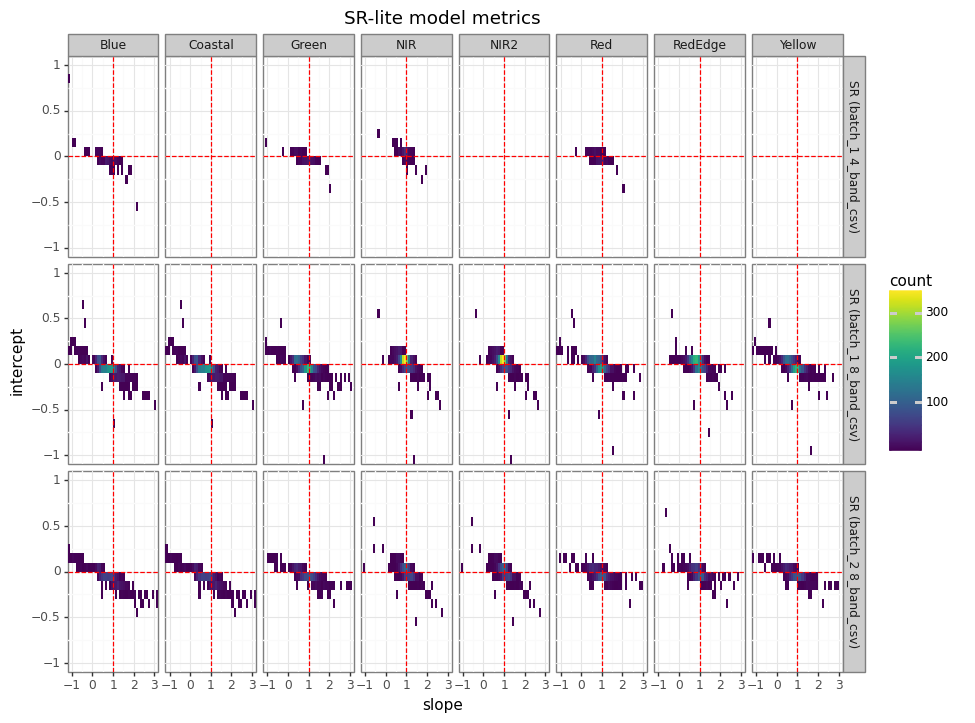

<ggplot: (1447099387859)>

In [238]:
(
    ggplot(srlite_metrics_df)
        + geom_bin2d(aes(x='slope', y='intercept'), binwidth=0.1)
        + geom_hline(yintercept=0, linetype='dashed', color='red')
        + geom_vline(xintercept=1, linetype='dashed', color='red')
        + facet_grid('type~band_name')
        + theme_bw()
        + coord_cartesian(xlim=(-1,3), ylim=(-1,1))
        + labs(title='SR-lite model metrics')
    + theme(figure_size=(10,8))
)

/home/pmontesa/.local/lib/python3.8/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_bin_2d : Removed 11124 rows containing non-finite values.


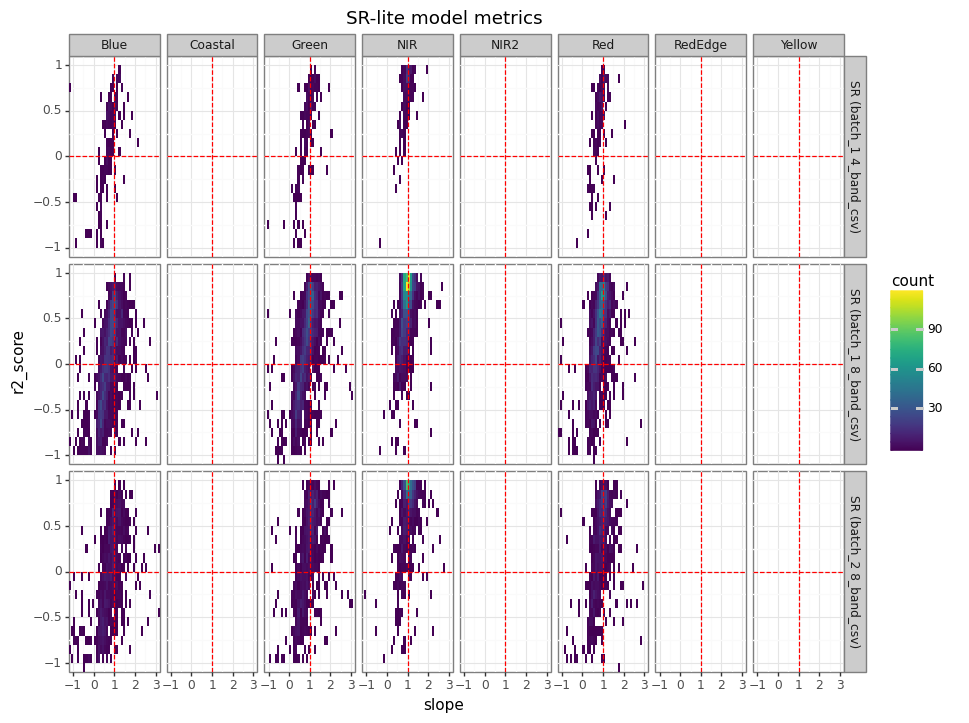

<ggplot: (1447098787946)>

In [239]:
(
    ggplot(srlite_metrics_df)
        + geom_bin2d(aes(x='slope', y='r2_score'), binwidth=0.1)
        + geom_hline(yintercept=0, linetype='dashed', color='red')
        + geom_vline(xintercept=1, linetype='dashed', color='red')
        + facet_grid('type~band_name')
        + theme_bw()
        + coord_cartesian(xlim=(-1,3), ylim=(-1,1))
        + labs(title='SR-lite model metrics')
    + theme(figure_size=(10,8))
)

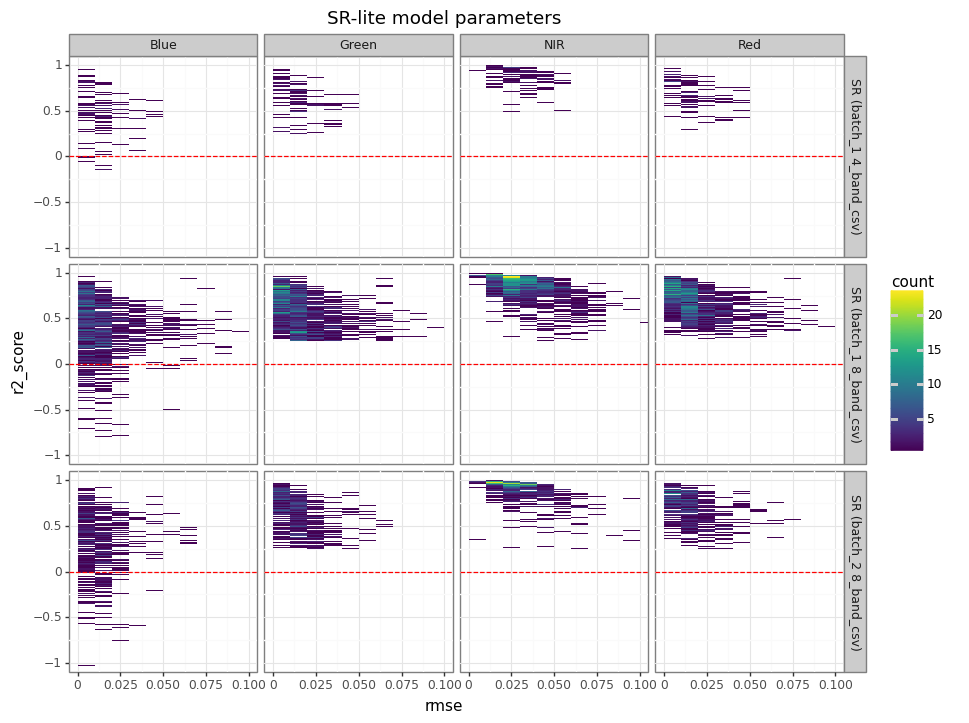

<ggplot: (1447099853111)>

In [240]:
(
    ggplot(SUBSET_DF.dropna())
        + geom_bin2d(aes(x='rmse', y='r2_score'), binwidth=0.01)
        + geom_hline(yintercept=0, linetype='dashed', color='red')
        + geom_vline(xintercept=1, linetype='dashed', color='red')
        + facet_grid('type~band_name')
        + theme_bw()
    + coord_cartesian(xlim=(0,0.1), ylim=(-1,1))
        + labs(title='SR-lite model parameters')
        + theme(figure_size=(10, 8), strip_text = element_text(size=9))
)

In [90]:
# (
#     ggplot(srlite_metrics_df.dropna())
#         + geom_point(aes(x='slope', y='r2_score', color='rmse'), size=0.25, alpha=0.91)
#         + geom_hline(yintercept=0, linetype='dashed', color='red')
#         + geom_vline(xintercept=1, linetype='dashed', color='red')
#         + facet_grid('type~band_name')
#         + theme_bw()
#     + coord_cartesian(xlim=(-1,3), ylim=(-1,1))
#         + labs(title='SR-lite model parameters')
#         + theme(figure_size=(9, 3), strip_text = element_text(size=9))
# )